In [1]:
import os
import sys

import tensorflow as tf
from tensorflow import keras
import keras.backend as K
import custom_loss_functions
import utils
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
from numpy import expand_dims

import requests
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import datetime
import csv
import pandas as pd
import json

import argparse

Using TensorFlow backend.


In [2]:
tf.__version__

'2.1.0'

In [3]:
keras.__version__

'2.2.4-tf'

In [4]:
if tf.config.list_physical_devices('GPU'):
    print("GPU was detected.")

GPU was detected.


# Load trained model

In [5]:
model_path = "saved_models/MSE/14-02-2020_15:10:24/CAE_mvtec_b24.h5"

In [6]:
# import importlib
# importlib.reload(utils)

In [7]:
model, setup, history = utils.load_model_HDF5(model_path)

In [9]:
# data setup
directory = setup["data_setup"]["directory"]
val_data_dir = os.path.join(directory, "train")
nb_training_images = setup["data_setup"]["nb_training_images"]
nb_validation_images = setup["data_setup"]["nb_validation_images"]

# preprocessing_setup
rescale = setup["preprocessing_setup"]["rescale"]
shape = setup["preprocessing_setup"]["shape"]
preprocessing = setup["preprocessing_setup"]["preprocessing"]

# train_setup
color_mode = setup["train_setup"]["color_mode"]
learning_rate = setup["train_setup"]["learning_rate"]
epochs_trained = setup["train_setup"]["epochs_trained"]
nb_training_images_aug = setup["train_setup"]["nb_training_images_aug"]
epochs = setup["train_setup"]["epochs"]
batch_size = setup["train_setup"]["batch_size"]
channels = setup["train_setup"]["channels"]
validation_split = setup["train_setup"]["validation_split"]
architecture = setup["train_setup"]["architecture"]
loss = setup["train_setup"]["loss"]

comment = setup["comment"]

In [10]:
import pandas as pd

In [53]:
history[['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']].head(5)

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,0.560723,0.560723,0.503719,0.503719
1,0.555046,0.555046,0.497923,0.497923
2,0.542670,0.542670,0.486321,0.486321
3,0.522331,0.522331,0.436812,0.436812
4,0.403957,0.403957,0.313171,0.313171


In [12]:
history = history[['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error']]

In [51]:
history.head(5)

,loss,mean_squared_error,val_loss,val_mean_squared_error
0,0.560723,0.560723,0.503719,0.503719
1,0.555046,0.555046,0.497923,0.497923
2,0.542670,0.542670,0.486321,0.486321
3,0.522331,0.522331,0.436812,0.436812
4,0.403957,0.403957,0.313171,0.313171


In [52]:
history.tail(5)

,loss,mean_squared_error,val_loss,val_mean_squared_error
45,0.016383,0.016383,0.014514,0.014514
46,0.016273,0.016273,0.013414,0.013414
47,0.015780,0.015780,0.014257,0.014257
48,0.015565,0.015565,0.013167,0.013167
49,0.014996,0.014996,0.012220,0.012220


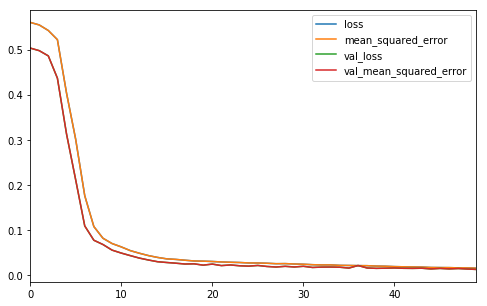

In [15]:
pd.DataFrame(history).plot(figsize=(8, 5))

## Predict on validation split (reconstruct defect-free validation images)

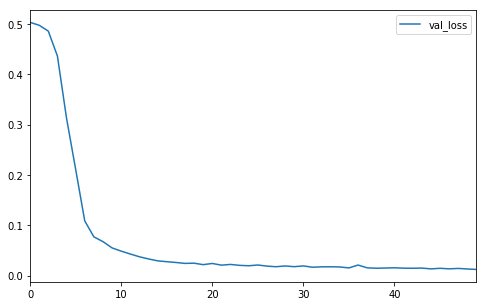

In [16]:
pd.DataFrame(history[['val_loss']]).plot(figsize=(8, 5))

In [20]:
# This will do preprocessing
if architecture == "mvtec":
    preprocessing_function = None
elif architecture == "resnet":
    preprocessing_function=keras.applications.inception_resnet_v2.preprocess_input
elif architecture == "nasnet":
        preprocessing_function = keras.applications.nasnet.preprocess_input

validation_datagen = ImageDataGenerator(
    rescale=rescale,
    data_format="channels_last",
    validation_split=validation_split,
    preprocessing_function=preprocessing_function,
)

In [23]:
# retrieve preprocessed input images as a numpy array
validation_generator = validation_datagen.flow_from_directory(
    directory=val_data_dir,
    target_size=shape,
    color_mode=color_mode,
    batch_size=nb_validation_images,
    shuffle=False,
    class_mode="input",
    subset="validation",
)

Found 21 images belonging to 1 classes.


In [29]:
imgs_input = validation_generator.next()[0]

In [30]:
imgs_input.shape

(21, 256, 256, 3)

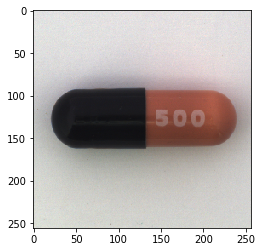

In [31]:
index = 3
plt.imshow(imgs_input[index])

In [83]:
filenames = validation_generator.filenames

In [84]:
filenames

['good/000.png',
 'good/001.png',
 'good/002.png',
 'good/003.png',
 'good/004.png',
 'good/005.png',
 'good/006.png',
 'good/007.png',
 'good/008.png',
 'good/009.png',
 'good/010.png',
 'good/011.png',
 'good/012.png',
 'good/013.png',
 'good/014.png',
 'good/015.png',
 'good/016.png',
 'good/017.png',
 'good/018.png',
 'good/019.png',
 'good/020.png']

In [33]:
def plot_img(imgs, index):
    if imgs.shape[-1] == 3:
        plt.imshow(imgs[index])
    else:
        plt.imshow(imgs[index,:,:,0], cmap=plt.cm.gray)
    plt.show()

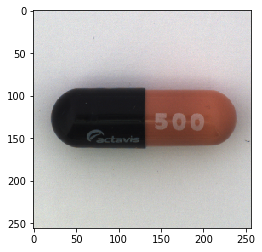

In [34]:
# plt.imshow(inputs[0]) # rgb
# plt.imshow(inputs[0,:,:,0], cmap=plt.cm.gray)
plot_img(imgs_input, 0)

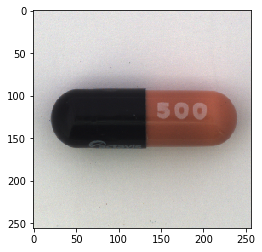

In [35]:
plot_img(imgs_input,10)

In [36]:
np.amax(imgs_input)

1.0

In [37]:
np.amin(imgs_input)

0.043137256

--------------------------------------------------------------------------------------------------

### Inspect reconstructions throught predict

In [38]:
imgs_pred = model.predict(imgs_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


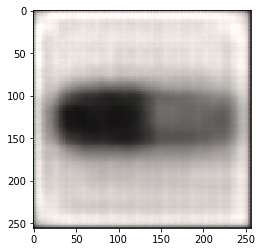

In [39]:
plot_img(imgs_pred, 0)

In [40]:
np.amax(imgs_pred)

1.1092252

In [41]:
np.amin(imgs_pred)

0.03852711

--------------------------------------------------------------------------------------------------

In [42]:
imgs_diff = imgs_input - imgs_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


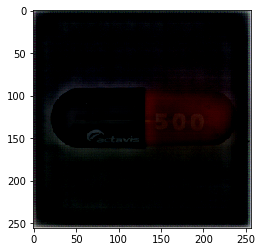

In [43]:
# plt.imshow(imgs_diff[20])
plot_img(imgs_diff, 0)

In [44]:
np.amax(imgs_diff)

0.8524062

In [45]:
np.amin(imgs_diff)

-0.42434192

### Compute residual maps

In [46]:
imgs_diff = imgs_input - imgs_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


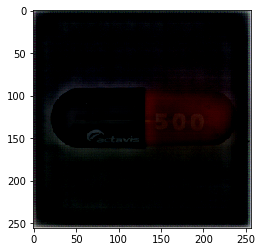

In [47]:
# plt.imshow(imgs_diff[0])
# plt.imshow(imgs_diff[0,:,:,0], cmap=plt.cm.gray)
plot_img(imgs_diff, index=0)

In [48]:
type(imgs_diff)

numpy.ndarray

In [49]:
imgs_diff_1d = imgs_diff.flatten()

(array([1.00000e+01, 1.34000e+02, 1.16600e+03, 4.15800e+03, 9.26200e+03,
        1.76730e+04, 3.43540e+04, 7.25740e+04, 1.38499e+05, 2.61701e+05,
        4.21387e+05, 6.62509e+05, 9.90115e+05, 7.21139e+05, 3.19633e+05,
        1.40075e+05, 8.38690e+04, 5.48200e+04, 4.13580e+04, 3.35320e+04,
        2.39530e+04, 1.43690e+04, 7.76200e+03, 4.62500e+03, 3.69200e+03,
        2.98400e+03, 3.06300e+03, 4.34700e+03, 5.80100e+03, 6.75200e+03,
        6.99200e+03, 9.01300e+03, 1.13600e+04, 9.45100e+03, 3.78200e+03,
        1.62000e+03, 7.62000e+02, 3.06000e+02, 1.25000e+02, 4.10000e+01]),
 array([-0.42434192, -0.3924232 , -0.3605045 , -0.3285858 , -0.2966671 ,
        -0.2647484 , -0.2328297 , -0.200911  , -0.1689923 , -0.13707359,
        -0.10515489, -0.07323618, -0.04131748, -0.00939878,  0.02251993,
         0.05443863,  0.08635733,  0.11827604,  0.15019473,  0.18211344,
         0.21403214,  0.24595085,  0.27786955,  0.30978826,  0.34170696,
         0.37362567,  0.40554437,  0.43746307,  0

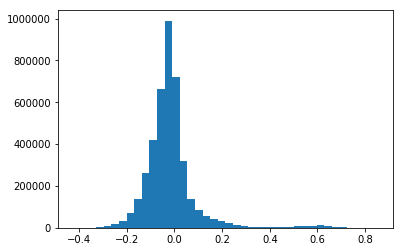

In [50]:
plt.hist(imgs_diff_1d, bins=40)

In [74]:
mean_val = np.mean(imgs_diff_1d)
std_val = np.std(imgs_diff_1d)

In [76]:
print("mean_val = {}".format(mean_val))
print("std_val = {}".format(std_val))

mean_val = -0.018150486052036285
std_val = 0.10904578864574432


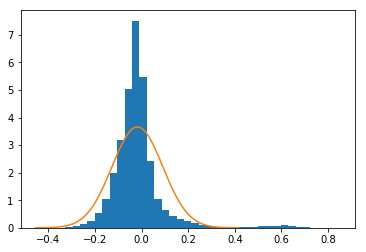

In [81]:
import scipy.stats
plt.hist(imgs_diff_1d, bins=40, density=True)
X_val = np.linspace(start=mean_val-4*std_val, stop=mean_val+4*std_val, num=1000, endpoint=True)
pdf_x_val = [scipy.stats.norm(mean_val, std_val).pdf(x_val) for x_val in X_val]
plt.plot(X_val,pdf_x_val)
plt.show()

------------------------------------------------------

## Inspect reconstructions of test images

In [55]:
test_data_dir = os.path.join(directory, "test")

In [56]:
# This will do preprocessing
if architecture == "mvtec":
    preprocessing_function = None
elif architecture == "resnet":
    preprocessing_function=keras.applications.inception_resnet_v2.preprocess_input
elif architecture == "nasnet":
        preprocessing_function = keras.applications.nasnet.preprocess_input

test_datagen = ImageDataGenerator(
    rescale=rescale,
    data_format="channels_last",
#     validation_split=validation_split,
    preprocessing_function=preprocessing_function,
)

In [57]:
# get the number of files in test directory
os.listdir(test_data_dir)

['scratch', 'squeeze', 'faulty_imprint', 'crack', 'good', 'poke']

In [59]:
total_number = 0
sub_dir_names = os.listdir(test_data_dir)
for sub_dir_name in sub_dir_names:
    sub_dir_path = os.path.join(test_data_dir, sub_dir_name)
    filenames = os.listdir(sub_dir_path)
    number = len(filenames)
    total_number = total_number + number
print(total_number)

132


In [60]:
# retrieve preprocessed input images as a numpy array
test_generator = test_datagen.flow_from_directory(
    directory=test_data_dir,
    target_size=shape,
    color_mode=color_mode,
    batch_size=total_number,
    shuffle=False,
    class_mode="input",
#     subset="validation",
)

Found 132 images belonging to 6 classes.


In [85]:
filenames = test_generator.filenames

In [86]:
filenames

['crack/000.png',
 'crack/001.png',
 'crack/002.png',
 'crack/003.png',
 'crack/004.png',
 'crack/005.png',
 'crack/006.png',
 'crack/007.png',
 'crack/008.png',
 'crack/009.png',
 'crack/010.png',
 'crack/011.png',
 'crack/012.png',
 'crack/013.png',
 'crack/014.png',
 'crack/015.png',
 'crack/016.png',
 'crack/017.png',
 'crack/018.png',
 'crack/019.png',
 'crack/020.png',
 'crack/021.png',
 'crack/022.png',
 'faulty_imprint/000.png',
 'faulty_imprint/001.png',
 'faulty_imprint/002.png',
 'faulty_imprint/003.png',
 'faulty_imprint/004.png',
 'faulty_imprint/005.png',
 'faulty_imprint/006.png',
 'faulty_imprint/007.png',
 'faulty_imprint/008.png',
 'faulty_imprint/009.png',
 'faulty_imprint/010.png',
 'faulty_imprint/011.png',
 'faulty_imprint/012.png',
 'faulty_imprint/013.png',
 'faulty_imprint/014.png',
 'faulty_imprint/015.png',
 'faulty_imprint/016.png',
 'faulty_imprint/017.png',
 'faulty_imprint/018.png',
 'faulty_imprint/019.png',
 'faulty_imprint/020.png',
 'faulty_imprint/02

In [61]:
imgs_test_input = test_generator.next()[0]

In [89]:
defective_true = [True if "good" in filename.split("/") else False for filename in filenames]

In [90]:
len(defective_true)

132

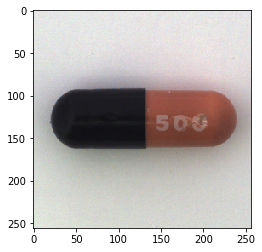

In [67]:
plot_img(imgs_test_input, 72)

In [68]:
imgs_test_pred = model.predict(imgs_test_input)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


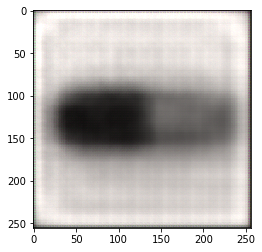

In [71]:
plot_img(imgs_test_pred, 72)

In [69]:
imgs_test_diff = imgs_test_input - imgs_test_pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


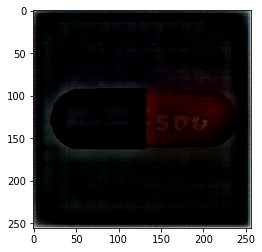

In [70]:
plot_img(imgs_test_diff, 72)

In [72]:
imgs_test_diff_1d = imgs_test_diff.flatten()

(array([1.00000e+01, 1.34000e+02, 1.16600e+03, 4.15800e+03, 9.26200e+03,
        1.76730e+04, 3.43540e+04, 7.25740e+04, 1.38499e+05, 2.61701e+05,
        4.21387e+05, 6.62509e+05, 9.90115e+05, 7.21139e+05, 3.19633e+05,
        1.40075e+05, 8.38690e+04, 5.48200e+04, 4.13580e+04, 3.35320e+04,
        2.39530e+04, 1.43690e+04, 7.76200e+03, 4.62500e+03, 3.69200e+03,
        2.98400e+03, 3.06300e+03, 4.34700e+03, 5.80100e+03, 6.75200e+03,
        6.99200e+03, 9.01300e+03, 1.13600e+04, 9.45100e+03, 3.78200e+03,
        1.62000e+03, 7.62000e+02, 3.06000e+02, 1.25000e+02, 4.10000e+01]),
 array([-0.42434192, -0.3924232 , -0.3605045 , -0.3285858 , -0.2966671 ,
        -0.2647484 , -0.2328297 , -0.200911  , -0.1689923 , -0.13707359,
        -0.10515489, -0.07323618, -0.04131748, -0.00939878,  0.02251993,
         0.05443863,  0.08635733,  0.11827604,  0.15019473,  0.18211344,
         0.21403214,  0.24595085,  0.27786955,  0.30978826,  0.34170696,
         0.37362567,  0.40554437,  0.43746307,  0

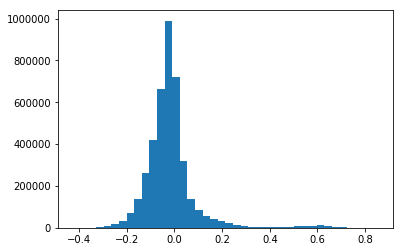

In [73]:
plt.hist(imgs_diff_1d, bins=40)

In [77]:
mean_test = np.mean(imgs_test_diff_1d)
std_test = np.std(imgs_test_diff_1d)

In [78]:
print("mean_val = {}".format(mean_val))
print("std_val = {}".format(std_val))

mean_val = -0.018150486052036285
std_val = 0.10904578864574432


In [79]:
print("mean_test = {}".format(mean_test))
print("std_test = {}".format(std_test))

mean_test = -0.013887166976928711
std_test = 0.10933975875377655


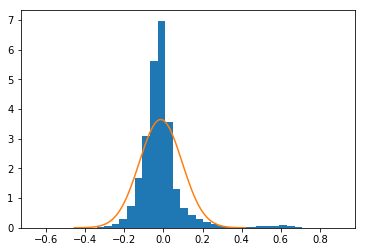

In [82]:
import scipy.stats
plt.hist(imgs_test_diff_1d, bins=40, density=True)
X_test = np.linspace(start=mean_val-4*std_test, stop=mean_val+4*std_test, num=1000, endpoint=True)
pdf_x_test = [scipy.stats.norm(mean_test, std_test).pdf(x_test) for x_test in X_test]
plt.plot(X_test,pdf_x_test)
plt.show()